# Video Game Skin Rater

## Purpose
Skins (the appearance of your avatar) is extremely similar to styling your own clothes in real life. Much like clothing, **we** would like to know if a particular skin looks good or not. Who's "we"? Both the consumers and providers. Although consumers care about whether or not they like a particular skin, they also care about whether or not other people like it. On the other hand, providers want to know if their gamers would like the skin they plan on releasing. How much consumers like a product can also influence the price point - they can base their cost on how highly their consumers would like the skin. 

**This is why I created a model to predict how the gaming community would rate skins.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# for scraping
import requests
from bs4 import BeautifulSoup

# for scraping/pre-processing images
from PIL import Image
from io import BytesIO

# image model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy as SCC
import tensorflow as tf
import math

# category model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Scraping the Data
Data will be scraped from a list of Fortnite skins online: https://progameguides.com/fortnite-skins-list/. There are hundreds of thousands of votes from the community rating every released skin. 

### Features
The features that will be scraped from this site are: the skin's name, which set it belongs in, its availability (shop vs. battle pass), how rare it is, its rating out of 5, the number of votes, the categories it belongs to, and the image of the skin.
- Scraped 1/13/2020

In [2]:
# Reading the site's contents
url = "https://progameguides.com/fortnite-skins-list/"
resp = requests.get(url)
soup = BeautifulSoup(resp.content, "html.parser")

In [3]:
# fetching skin names
skin_name = [x.find("strong") for x in soup.find_all("a")]
skin_name = [x.text for x in skin_name if x]
skin_name[:5]

['8-Ball vs Scratch', 'A.I.M.', 'Absolute Zero', 'Abstrakt', 'Adeline']

In [4]:
print(len(skin_name), "skins per page.")

20 skins per page.


In [5]:
# each element in the line below has: set, availability, and rarity
set_avail_rare = soup.find_all("div", {"class":"text-small text-center"})
set_avail_rare = [x.find_all("a") for x in set_avail_rare]

# fetching sets
skin_set = [x[0].text for x in set_avail_rare]

# fetching availabilities - x[1] and x[2] don't work bc some skins don't have availability
avail = []
for i in range(len(set_avail_rare)):
    try:
        avail.append(set_avail_rare[i][1].text)
    except:
        avail.append("Unreleased")
        
# fetching rarities
rarity = [x[-1].text for x in set_avail_rare]

skin_set[:3], avail[:3], rarity[:3]

(['Stripes and Solids', 'A.I.M.', 'Arctic Command'],
 ['Battle Pass', 'Battle Pass', 'Shop'],
 ['Epic', 'Legendary', 'Rare'])

When gathering the availability of skins, the expected code did not work because some skins don't have an availability, meaning that they are unreleased. These will be removed from the dataset.

In [6]:
rate_votes = soup.find_all("div", {"class": "gdrts-rating-text"})
rate_votes = [x.text.replace("\n", "").strip() for x in rate_votes]
print("current output - ", rate_votes[0])

# fetching ratings and votes
rating = [x.split(" ")[1][:-1] for x in rate_votes]
num_votes = [x.split(" ")[3] for x in rate_votes]

rating[:3], num_votes[:3]

current output -  Rating: 3.9/5. From 10.0K votes.


(['3.9/5', '3.1/5', '2.7/5'], ['10.0K', '14.6K', '11.7K'])

Scraping the last two features, skin images and categories, requires opening the skin's own url. Regarding the skin images, there are images from the previous url, but there are more suitable ones in the skin's url. Given this, these two categories will be scraped after I gather the previous categories for all of the skins.

**All pages**

In [7]:
# there are 48 pages
url_template = "https://progameguides.com/fortnite-skins-list/page/{}/"

all_names, all_sets, all_avail, all_rarity, all_ratings, all_votes = [], [], [], [], [], []

for i in range(48):
    url = url_template.format(i)
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    
    # skin name
    skin_name = [x.find("strong") for x in soup.find_all("a")]
    skin_name = [x.text for x in skin_name if x]
    
    set_avail_rare = soup.find_all("div", {"class":"text-small text-center"})
    set_avail_rare = [x.find_all("a") for x in set_avail_rare]

    # set
    skin_set = [x[0].text for x in set_avail_rare]

    # availability
    avail = []
    for i in range(len(set_avail_rare)):
        try:
            avail.append(set_avail_rare[i][1].text)
        except:
            avail.append("Unreleased")

    # rarity
    rarity = [x[-1].text for x in set_avail_rare]
    
    # rating and num votes
    rate_votes = soup.find_all("div", {"class": "gdrts-rating-text"})
    rate_votes = [x.text.replace("\n", "").strip() for x in rate_votes]
    rating = [x.split(" ")[1][:-1] for x in rate_votes]
    num_votes = [x.split(" ")[3] for x in rate_votes]
    
    all_names += skin_name
    all_sets += skin_set
    all_avail += avail
    all_rarity += rarity
    all_ratings += rating
    all_votes += num_votes

In [8]:
skins = pd.DataFrame({"name": all_names, "set": all_sets, "availability": all_avail, 
                      "rarity": all_rarity, "rating": all_ratings, "num_votes": all_votes})
print(skins.shape)
skins.head()

(960, 6)


,name,set,availability,rarity,rating,num_votes
0,8-Ball vs Scratch,Stripes and Solids,Battle Pass,Epic,3.9/5,10.0K
1,A.I.M.,A.I.M.,Battle Pass,Legendary,3.1/5,14.6K
2,Absolute Zero,Arctic Command,Shop,Rare,2.7/5,11.7K
3,Abstrakt,Aerosol Assassins,Shop,Epic,3.2/5,11.9K
4,Adeline,Colorway,Shop,Rare,3.3/5,941


### Categories and Images
* To reiterate, there are direct image urls in the html, but I prefer the images of skins that do not have the colorful background so the model can focus on the skin only since I will be keeping the images as RGBA. Skin images without colorful backgrounds are found within the skin's url. These urls are also required to get the categories.

Getting all of the skin urls to get the categories and skin images.

In [3]:
# loading contents
url = "https://progameguides.com/fortnite-skins-list/"
resp = requests.get(url)
soup = BeautifulSoup(resp.content, "html.parser")

In [10]:
# fetching the urls of all skins
all_skin_urls = []
for i in range(48):
    url = url_template.format(i)
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    
    a = [str(x) for x in soup.find_all("a")]
    skin_urls = [x.split(" ") for x in a if "fortnite-cosmetic" in x]
    skin_urls = [x[1].split(">")[0][6:-1] for i,x in enumerate(skin_urls) if (i % 2 == 1)]
    all_skin_urls += skin_urls
    
all_skin_urls[-3:]

['https://progameguides.com/fortnite-cosmetic/yule-trooper/',
 'https://progameguides.com/fortnite-cosmetic/yuletide-ranger/',
 'https://progameguides.com/fortnite-cosmetic/zadie/']

In [11]:
# fetching categories
all_categories = []
for url in all_skin_urls:
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    various_info = soup.find_all("ul")[-2].find_all("a")
    categories = []
    for info in various_info:
        categories.append(info.text)
    all_categories.append(categories[3:])

In [12]:
skins['categories'] = all_categories
skins.head()

,name,set,availability,rarity,rating,num_votes,categories
0,8-Ball vs Scratch,Stripes and Solids,Battle Pass,Epic,3.9/5,10.0K,"[Enlightened, Male, Styles]"
1,A.I.M.,A.I.M.,Battle Pass,Legendary,3.1/5,14.6K,"[Male, Mystery Skin, Robot]"
2,Absolute Zero,Arctic Command,Shop,Rare,2.7/5,11.7K,[Male]
3,Abstrakt,Aerosol Assassins,Shop,Epic,3.2/5,11.9K,[Male]
4,Adeline,Colorway,Shop,Rare,3.3/5,941,[Styles]


In [13]:
# getting the skin image urls from skin urls
pic_urls = []
for url in all_skin_urls:
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    try:
        pic_url = soup.find_all("a", {"class": "set-target"})[-1].img["src"]
        
        # some don't go by "src" - these go by "data-lazy-src"
        if pic_url == "data:image/svg+xml,%3Csvg%20xmlns='http://www.w3.org/2000/svg'%20viewBox='0%200%20300%20300'%3E%3C/svg%3E":
            pic_url = soup.find_all("a", {"class": "set-target"})[-2].img["data-lazy-src"]
        
        pic_urls.append(pic_url)
    except:
        pic_urls.append("No skin image")   # some are unreleased and don't have suitable pictures - will be removed

In [14]:
# checking value counts since skins should have unique picture links
pics = pd.DataFrame({"url": pic_urls})
pics['url'].value_counts()[:4]

No skin image                                                                                                166
data:image/svg+xml,%3Csvg%20xmlns='http://www.w3.org/2000/svg'%20viewBox='0%200%20900%20506'%3E%3C/svg%3E     29
data:image/svg+xml,%3Csvg%20xmlns='http://www.w3.org/2000/svg'%20viewBox='0%200%20450%20450'%3E%3C/svg%3E      9
https://progameguides.com/wp-content/uploads/2018/11/fortnite-1920x1080-wallpaper-nfl001-450x450.jpg           6
Name: url, dtype: int64

After checking the value counts of skin image urls, I noticed that sometimes wallpapers were scraped instead of the skin images. These particular skins need to be scraped differently and replaced.

In [15]:
print("There are {} wallpapers instead of skins.".format(len(pics[pics['url'].str.contains("wallpaper")])))
wallpapers = pics[pics['url'].str.contains("wallpaper")]
wallpapers.head()

There are 105 wallpapers instead of skins.


,url
3,https://progameguides.com/wp-content/uploads/2...
7,https://progameguides.com/wp-content/uploads/2...
12,https://progameguides.com/wp-content/uploads/2...
23,https://progameguides.com/wp-content/uploads/2...
27,https://progameguides.com/wp-content/uploads/2...


In [16]:
# replacing wallpapers with their skin images
for i,url in enumerate(all_skin_urls):
    if i in wallpapers.index:
        soup = BeautifulSoup(requests.get(url).content, "html.parser")
        pic_url = soup.find_all("a", {"class": "set-target"})[1].img["src"]
        pic_urls[i] = pic_url

In [17]:
pics = pd.DataFrame({"url": pic_urls})
wallpapers = pics[pics['url'].str.contains("wallpaper")]
print(len(wallpapers), "wallpapers remain to be replaced.")

1 wallpapers remain to be replaced.


In [18]:
# replacing the remaining wallpapers
for i,url in enumerate(all_skin_urls):
    if i in wallpapers.index:
        soup = BeautifulSoup(requests.get(url).content, "html.parser")
        pic_url = soup.find_all("a", {"class": "set-target"})[0].img["src"]
        pic_urls[i] = pic_url

In [19]:
pics = pd.DataFrame({"url": pic_urls})
wallpapers = pics[pics['url'].str.contains("wallpaper")]
print(len(wallpapers), "wallpapers remain to be replaced.")

0 wallpapers remain to be replaced.


Before getting the images, the urls need to be cleaned by:
* Removing skins that don't have images
* Removing the skins that don't have 300x300 images (note that these can be reshaped instead)

In [20]:
# removing the skins that don't have images
skins["pic"] = pic_urls
skins = skins[skins["pic"] != "No skin image"]
print(skins.shape)
skins.head()

(794, 8)


,name,set,availability,rarity,rating,num_votes,categories,pic
0,8-Ball vs Scratch,Stripes and Solids,Battle Pass,Epic,3.9/5,10.0K,"[Enlightened, Male, Styles]",https://progameguides.com/wp-content/uploads/2...
1,A.I.M.,A.I.M.,Battle Pass,Legendary,3.1/5,14.6K,"[Male, Mystery Skin, Robot]",https://progameguides.com/wp-content/uploads/2...
2,Absolute Zero,Arctic Command,Shop,Rare,2.7/5,11.7K,[Male],https://progameguides.com/wp-content/uploads/2...
3,Abstrakt,Aerosol Assassins,Shop,Epic,3.2/5,11.9K,[Male],https://progameguides.com/wp-content/uploads/2...
4,Adeline,Colorway,Shop,Rare,3.3/5,941,[Styles],https://progameguides.com/wp-content/uploads/2...


In [25]:
skins = skins[~skins["pic"].str.contains("data:image")]
skins.shape

(744, 8)

## Cleaning the Dataset

In [27]:
# dropping duplicates - can't have categories contain lists
skins['categories'] = skins['categories'].apply(str)
skins = skins.drop_duplicates()
skins.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(722, 8)

In [28]:
def clean_rating(rate):
    """Turns rating from (ie.) 3.9/5 to 3.9"""
    rate = rate[:-2]
    return float(rate)

def clean_votes(vote):
    """Turns num_votes from (ie.) 14.6K to 14600"""
    if "K" in vote:
        vote = vote[:-1] + "00"
        vote = vote.replace(".", "")
    return int(vote)

def clean_categories(row):
    """Changes the category from a string of a list to a list."""
    row = row[1:-1]
    row = row.replace("'", "").split(",")
    for i in range(len(row)):
        row[i] = row[i].strip()
    return row
        
skins['rating'] = skins['rating'].apply(clean_rating)
skins['num_votes'] = skins['num_votes'].apply(clean_votes)
skins['categories'] = skins['categories'].apply(clean_categories)
skins.head()

,name,set,availability,rarity,rating,num_votes,categories,pic
0,8-Ball vs Scratch,Stripes and Solids,Battle Pass,Epic,3.9,10000,"[Enlightened, Male, Styles]",https://progameguides.com/wp-content/uploads/2...
1,A.I.M.,A.I.M.,Battle Pass,Legendary,3.1,14600,"[Male, Mystery Skin, Robot]",https://progameguides.com/wp-content/uploads/2...
2,Absolute Zero,Arctic Command,Shop,Rare,2.7,11700,[Male],https://progameguides.com/wp-content/uploads/2...
3,Abstrakt,Aerosol Assassins,Shop,Epic,3.2,11900,[Male],https://progameguides.com/wp-content/uploads/2...
4,Adeline,Colorway,Shop,Rare,3.3,941,[Styles],https://progameguides.com/wp-content/uploads/2...


After EDA, the uncommon categories will be removed to lower dimensionality.

### Fixing "Availability"

I also noticed that some availability cells are the same as the rarity skills. An example above is row 4, where both availability and rarity entries are "Rare".

In [29]:
len(skins[skins['rarity'] == skins['availability']])

87

There are 87 of these rows. Looking at the Airhead skin where both of the entries are "Rare" (https://progameguides.com/fortnite-cosmetic/airhead/), the site says that Availability should be "Shop". These 104 rows were scraped incorrectly and need to be fixed.

In [30]:
same_entries = skins[skins['rarity'] == skins['availability']]
urls = pd.DataFrame({"name": all_names, "url": all_skin_urls})
urls = urls[urls['name'].isin(same_entries['name'])].drop_duplicates()
print(urls.shape)
urls.head()

(87, 2)


,name,url
11,Airhead,https://progameguides.com/fortnite-cosmetic/ai...
50,Armadillo,https://progameguides.com/fortnite-cosmetic/ar...
52,﻿Assault Trooper,https://progameguides.com/fortnite-cosmetic/as...
54,Astro Assassin,https://progameguides.com/fortnite-cosmetic/as...
58,Aura,https://progameguides.com/fortnite-cosmetic/aura/


In [31]:
# fixing availabilities
fixed_avails = []
for url in urls['url']:
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    try:
        fixed_avails.append(soup.find_all("li")[13].find("a").text)
    except:
        fixed_avails.append("Errored")

In [32]:
pd.Series(fixed_avails).value_counts()

Shop       65
Errored    18
Male        4
dtype: int64

22 availabilities remain to be fixed.

In [33]:
# availabilities that still need to be fixed
urls['fixed avail'] = fixed_avails
to_fix = urls[urls['fixed avail'] != 'Shop']

# fixing more availabilities
more_fixed_avails = []
for url in to_fix['url']:
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    try:
        more_fixed_avails.append(soup.find_all("li")[9].find("a").text)
    except:
        more_fixed_avails.append("Errored")

In [34]:
# updating the availabilities with the fixed ones
to_fix['fixed avail'] = more_fixed_avails
urls.update(to_fix)
urls['fixed avail'].value_counts()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shop             65
Promotion         9
Epic              4
Legendary         2
Outfit            2
Battle Pass       2
Errored           1
Shadow Series     1
Unreleased        1
Name: fixed avail, dtype: int64

The only valid categories for "Availability" in these options are Shop, Promotion, Battle Pass, and Unreleased. This means that 10 rows remain to be fixed.

In [35]:
# availabilities that still need to be fixed
to_fix = urls[~urls['fixed avail'].isin(["Shop", "Promotion", "Battle Pass", "Unreleased"])]

# fixing more availabilities
more_fixed_avails = []
for url in to_fix['url']:
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    try:
        more_fixed_avails.append(soup.find_all("li")[10].find("a").text)
    except:
        more_fixed_avails.append("Errored")

In [36]:
# updating the remaining availabilities with the fixed ones
to_fix['fixed avail'] = more_fixed_avails
urls.update(to_fix)
urls['fixed avail'].value_counts()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shop           65
Promotion      11
Outfit          7
Battle Pass     2
Male            1
Unreleased      1
Name: fixed avail, dtype: int64

9 rows remain to be fixed.

In [37]:
# availabilities that still need to be fixed
to_fix = urls[~urls['fixed avail'].isin(["Shop", "Season Shop", "Promotion", "Battle Pass", "Unreleased"])]

# fixing more availabilities
more_fixed_avails = []
for url in to_fix['url']:
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    try:
        more_fixed_avails.append(soup.find_all("li")[11].find("a").text)
    except:
        more_fixed_avails.append("Errored")

In [38]:
# updating the remaining availabilities with the fixed ones
to_fix['fixed avail'] = more_fixed_avails
urls.update(to_fix)
urls['fixed avail'].value_counts()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shop           65
Promotion      11
Battle Pass     4
Bundle          4
Errored         2
Unreleased      1
Name: fixed avail, dtype: int64

2 rows remain to be fixed!

In [39]:
# availabilities that still need to be fixed
to_fix = urls[~urls['fixed avail'].isin(["Bundle", "Shop", "Season Shop", "Promotion", "Battle Pass", "Unreleased"])]
to_fix.head()

,name,url,fixed avail
444,K-Pop,https://progameguides.com/fortnite-cosmetic/k-...,Errored
583,P.A.N.D.A. Team Leader,https://progameguides.com/fortnite-cosmetic/p-...,Errored


Since there are only 2 rows left to be fixed, I can quickly open the links to see the two remaining availabilities.

In [40]:
# updating the remaining availabilities with the fixed ones
to_fix['fixed avail'] = ['Unreleased', 'Bundle']
urls.update(to_fix)
urls['fixed avail'].value_counts()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shop           65
Promotion      11
Bundle          5
Battle Pass     4
Unreleased      2
Name: fixed avail, dtype: int64

In [41]:
# updating the main dataframe
for i in range(len(urls)):
    skins.loc[skins['name'] == urls['name'].iloc[i], 'availability'] = urls['fixed avail'].iloc[i]
    
skins['availability'].value_counts()

Shop           552
Battle Pass     84
Bundle          54
Promotion       24
Unreleased       7
Season Shop      1
Name: availability, dtype: int64

In [42]:
# last corrections, "Cash Shop" just means "Shop"
skins.loc[skins['availability'] == "Cash Shop", 'availability'] = "Shop"
skins.loc[skins['availability'] == "Rare", 'availability'] = 'Unreleased'
skins.loc[skins['availability'] == "Uncommon", 'availability'] = 'Shop'

In [43]:
skins['availability'].value_counts()

Shop           552
Battle Pass     84
Bundle          54
Promotion       24
Unreleased       7
Season Shop      1
Name: availability, dtype: int64

### Fixing "Set"

Some of the "set" cells contain "Shop", "Promotion", etc. - these were scraped incorrectly.

In [44]:
skins["set"].value_counts().head()

Shop              66
Winter Ski        14
Promotion         11
Boundless          9
Banner Brigade     8
Name: set, dtype: int64

In [45]:
to_fix = skins[skins["set"].isin(["Bundle", "Shop", "Season Shop", "Promotion", "Battle Pass"])]
to_fix.shape

(85, 8)

85 rows need to be fixed.

I opened 10 urls for the skins that need to be fixed, and they all did not belong to a set (says "No Set" without a hyperlink), which is why they were scraped incorrectly. When they don't belong to a set, their set name is just their skin name.

In [46]:
to_fix['set'] = to_fix['name']
skins.update(to_fix)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
skins['set'].value_counts().head()

Winter Ski    14
Boundless      9
Permafrost     8
Goalbound      8
Dead Ball      8
Name: set, dtype: int64

In [48]:
# skins.to_csv("fortnite_skins.csv", index=False)

## Exploratory Data Analysis

In [50]:
skins = pd.read_csv("fortnite_skins.csv")
skins.head()

,name,set,availability,rarity,rating,num_votes,categories,pic
0,8-Ball vs Scratch,Stripes and Solids,Battle Pass,Epic,3.9,10000.0,"['Enlightened', 'Male', 'Styles']",https://progameguides.com/wp-content/uploads/2...
1,A.I.M.,A.I.M.,Battle Pass,Legendary,3.1,14600.0,"['Male', 'Mystery Skin', 'Robot']",https://progameguides.com/wp-content/uploads/2...
2,Absolute Zero,Arctic Command,Shop,Rare,2.7,11700.0,['Male'],https://progameguides.com/wp-content/uploads/2...
3,Abstrakt,Aerosol Assassins,Shop,Epic,3.2,11900.0,['Male'],https://progameguides.com/wp-content/uploads/2...
4,Adeline,Colorway,Shop,Rare,3.3,941.0,['Styles'],https://progameguides.com/wp-content/uploads/2...


In [51]:
orig_shape = skins.shape
orig_shape

(722, 8)

### Set

In [55]:
print("min number of skins per set:", skins.groupby('set').size().min())
print("max number of skins per set:", skins.groupby('set').size().max())
print("average number of skins per set:", round(skins.groupby('set').size().mean()))

min number of skins per set: 1
max number of skins per set: 14
average number of skins per set: 2


When a skin doesn't belong to a set, its set name is its skin name. Looking at how the average is pulled towards 1 despite having a max of 14, it's apparent that most sets only have 1 skin - I will look at sets that have a count higher than 2.

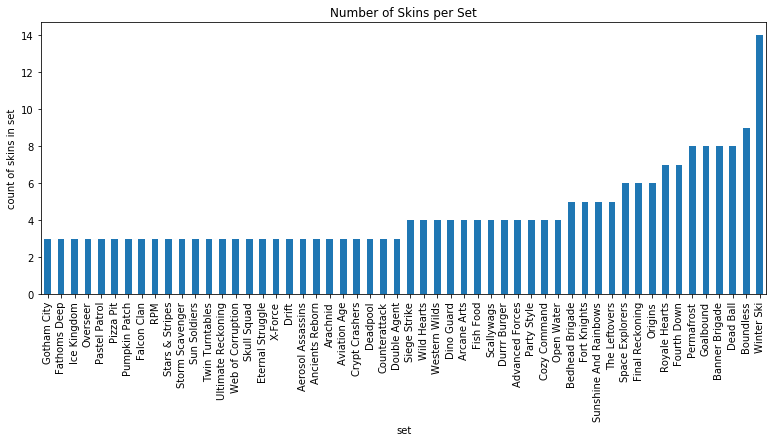

In [56]:
plt.figure(figsize=(13,5))
skins.groupby('set').filter(lambda x: len(x) > 2).groupby('set').size().sort_values().plot(kind='bar')
plt.ylabel('count of skins in set')
plt.title('Number of Skins per Set');

In [57]:
len(skins.groupby('set').filter(lambda x: len(x) < 2))

298

In [58]:
len(skins[skins['set'] == 'Winter Ski']), len(skins[skins['set'] == 'Boundless'])

(14, 9)

* 298 skins do not belong to a set (set size == 1). 
* The Winter Ski set contains the most skins. It contains 14 skins.
* The Boundless set contains the 2nd most skins, containing 9 skins.

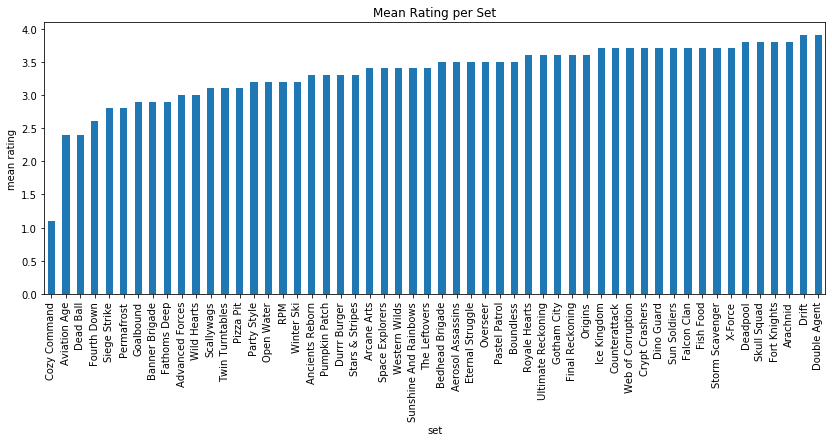

In [59]:
plt.figure(figsize=(14,5))
skins.groupby('set').filter(lambda x: len(x) > 2).groupby('set').mean()['rating'].round(1).sort_values().plot(kind='bar')
plt.ylabel('mean rating')
plt.title('Mean Rating per Set');

In [60]:
round(skins.groupby('set').filter(lambda x: len(x) > 2).groupby('set').mean()['rating'].mean(), 2)

3.33

The average mean rating of a set is 3.33 among the sets that contain at least 3 skins.

The highest mean rating of a set is around 3.9 rewarded to the Double Agent set, while the lowest is about 2.4 given to the Aviation Age set. Let's look at these sets.
* Note: Cozy Command is the lowest, but it contains outliers that get removed a few lines later.

In [61]:
skins[skins['set'] == 'Aviation Age']

,name,set,availability,rarity,rating,num_votes,categories,pic
10,Airheart,Aviation Age,Shop,Rare,2.5,9300.0,['Female'],https://progameguides.com/wp-content/uploads/2...
126,Cloudbreaker,Aviation Age,Shop,Rare,2.2,4300.0,['Male'],https://progameguides.com/wp-content/uploads/2...
380,Maximilian,Aviation Age,Shop,Rare,2.4,2700.0,['Male'],https://progameguides.com/wp-content/uploads/2...


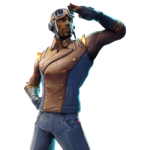

In [62]:
url = skins[skins['set'] == 'Aviation Age']['pic'].iloc[2]
resp = requests.get(url)
img = Image.open(BytesIO(resp.content))
img.resize((150,150))

In [63]:
skins[skins['set'] == 'Double Agent']

,name,set,availability,rarity,rating,num_votes,categories,pic
246,Chaos Double Agent,Double Agent,Bundle,Epic,3.9,1600.0,"['Male', 'Styles']",https://progameguides.com/wp-content/uploads/2...
247,Double Agent Hush,Double Agent,Bundle,Epic,3.9,1300.0,"['Female', 'Styles']",https://progameguides.com/wp-content/uploads/2...
249,Double Agent Wildcard,Double Agent,Bundle,Epic,3.9,1300.0,"['Male', 'Styles']",https://progameguides.com/wp-content/uploads/2...


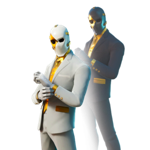

In [64]:
url = skins[skins['set'] == 'Double Agent']['pic'].iloc[2]
resp = requests.get(url)
img = Image.open(BytesIO(resp.content))
img.resize((150,150))

Looking at the two different skin images, it is easy to see that the 2nd image would be rated higher than the 1st image. Hopefully the model finds it as easy!

### Availability

In [65]:
skins['availability'].value_counts()

Shop           552
Battle Pass     84
Bundle          54
Promotion       24
Unreleased       7
Season Shop      1
Name: availability, dtype: int64

In [66]:
len(skins['availability'].value_counts())

6

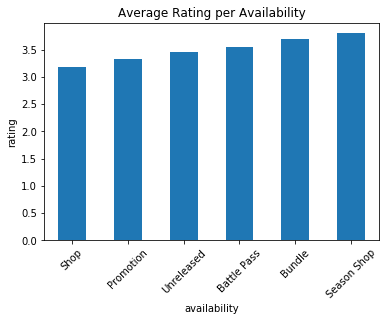

In [67]:
# avg rating per availability
skins.groupby('availability').mean()['rating'].sort_values().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('rating')
plt.title("Average Rating per Availability");

* There are 6 different availability options in this dataset.
* A large majority of the skins are available through the shop.
* Ignoring the Season Shop option because it only has 1 skin in this dataset, the Bundle skins are rated the highest on average. 
    * This is good because sometimes in game markets, you can only buy a skin if you purchase the entire bundle it is in. To make more money, a strategy is to pair a good skin with a bad one so they pay more despite only using the good skin.
* The battle pass skins are fairly liked (3.5/5). 
    * This is a good overall rating to achieve for the battle passes because as a consumer, I only buy a battle pass because 1) it's cheap (usually $10) for the amount of skins you're getting even if I don't plan on using most of them and 2) I see at least 2 decent skins to use so I can justify them as 5 dollars each.
* Seeing the Shop average rating, 3.2 is very good because the skins in the shop contains all different types of rarity categories, from Common to Legendary.

### Rarity

In [68]:
skins['rarity'].value_counts()

Epic              246
Rare              227
Uncommon          108
Legendary          80
Marvel             23
Shadow              7
DC                  6
Slurp               6
Icon                5
Dark                5
Star Wars           3
Frozen              2
Lava                2
Unreleased          1
Gaming Legends      1
Name: rarity, dtype: int64

There should not be an Unreleased option for rarity. Since there is only one skin out of hundreds that is misplaced (and wasn't released to the public), it will be removed.

In [69]:
# removing the misplaced row
skins = skins[skins['rarity'] != 'Unreleased']

In [70]:
len(skins['rarity'].value_counts())

14

* There are 14 different rarity types in this dataset.

The 4 most common rarity types are uncommon, rare, epic, and legendary. Let's look at each one of these.

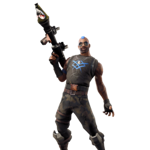

In [71]:
url = skins[skins['rarity'] == 'Uncommon']['pic'].iloc[0]
resp = requests.get(url)
img = Image.open(BytesIO(resp.content))
img.resize((150,150))

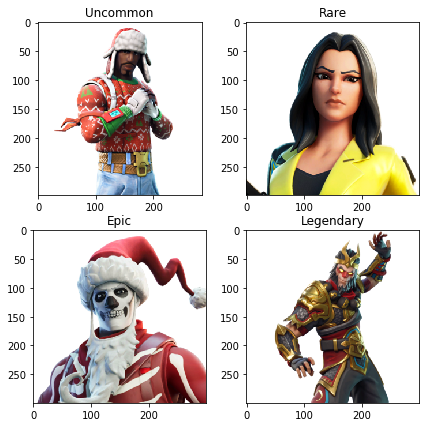

In [73]:
fig, ax = plt.subplots(2,2,figsize=(7,7))

rarity_type, x = ["Uncommon", "Rare", "Epic", "Legendary"], 0
for i in range(2):
    for j in range(2):
        url = skins[skins['rarity'] == rarity_type[x]]['pic'].iloc[-1]
        resp = requests.get(url)
        img = Image.open(BytesIO(resp.content))
        ax[i][j].imshow(img, cmap=plt.cm.binary)
        ax[i][j].set_title(rarity_type[x])
        x += 1

* Looking at the different rarities, you can see the difference in quality.

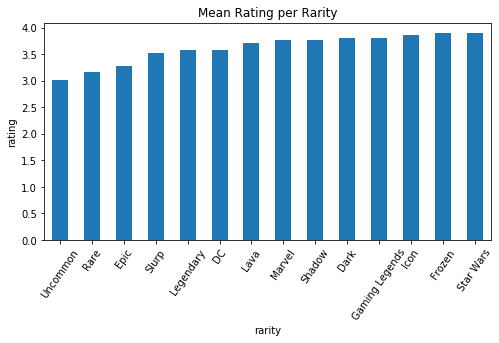

In [74]:
plt.figure(figsize=(8,4))
skins.groupby('rarity').mean()['rating'].sort_values().plot(kind='bar')
plt.xticks(rotation=55)
plt.ylabel("rating")
plt.title("Mean Rating per Rarity");

Looking at the rarity categories, the community likes the Star Wars skins the most, but there are only 3 skins in this category, unlike Marvel. Marvel has 23 skins and a rating that isn't very far off from the Star Wars rating (~0.2 difference). 
* From these 2 categories alone, I would say that the community tends to favor fantasy skins. 
    * The DC skins are fantasy but are also rated a bit lower, which makes sense because (to me) DC is less popular than Marvel and Star Wars outside of skin designs.
* The runner up is Frozen (not the movie unlike Marvel/Star Wars), where each skin is of a light blue color and contains some sort of snow or ice.
* The 3rd favorited is Icon, which is a series that contains skins of real-life people. Examples are skins of Marshmello (the DJ), Travis Scott, and other famous Fortnite players (Ninja, Lachlan, Loserfruit, etc.).

**Overall, it is apparent that *the community likes skins that resemble a known figure* such as Star Wars, Icon, Marvel, DC, etc. versus skins made up by the company.**

### Rating

In [75]:
print("min rating:", round(skins['rating'].min(), 2))
print("max rating:", round(skins['rating'].max(), 2))
print("average rating:", round(skins['rating'].mean(), 2))

min rating: 0.3
max rating: 4.0
average rating: 3.27


A rating of 0.3 is abnormally low. Let's see more details about this/these skin(s).

In [76]:
skins[skins['rating'] == .3]

,name,set,availability,rarity,rating,num_votes,categories,pic
292,Holly Jammer,Cozy Command,Shop,Uncommon,0.3,1100.0,"['Annual', 'Christmas', 'Female', 'Holidays', ...",https://progameguides.com/wp-content/uploads/2...
323,Jolly Jammer,Cozy Command,Shop,Uncommon,0.3,1900.0,"['Annual', 'Christmas', 'Female', 'Holidays', ...",https://progameguides.com/wp-content/uploads/2...
455,PJ Patroller,Cozy Command,Shop,Uncommon,0.3,1100.0,"['Annual', 'Christmas', 'Female', 'Holidays', ...",https://progameguides.com/wp-content/uploads/2...


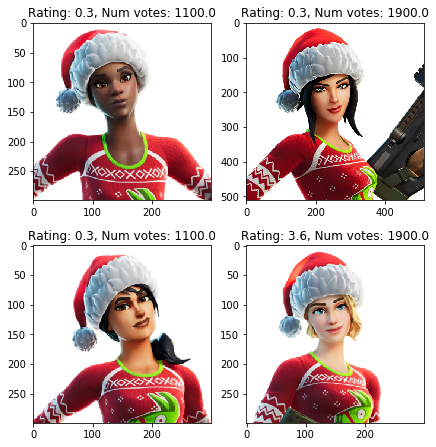

In [84]:
# all of the skins in its set
cozy_skins = skins[skins['set'] == 'Cozy Command'].sort_values('rating')

fig, ax = plt.subplots(2,2,figsize=(7,7.5))

x = 0
for i in range(2):
    for j in range(2):
        url = cozy_skins['pic'].iloc[x]
        resp = requests.get(url)
        img = Image.open(BytesIO(resp.content))
        ax[i][j].imshow(img, cmap=plt.cm.binary)
        ax[i][j].set_title("Rating: {}, Num votes: {}".format(cozy_skins['rating'].iloc[x], cozy_skins['num_votes'].iloc[x]))
        x += 1

The three skins with a 0.3 rating look extremely similar to the other skin in this set that has a rating of 3.6. 

To investigate why people might really hate these skins compared to the blonde version, I looked at the comments of these urls and some state that the ratings of these 3 skins are glitched. Other comments show that people truly like these skins. Due to this, I am going to remove these 3 skins from the dataset.

In [86]:
# dropping the 3 skins
skins = skins[skins['rating'] != 0.3]

In [87]:
skins[skins['rating'] < 2]

,name,set,availability,rarity,rating,num_votes,categories,pic
6,Aerobic Assassin,Spandex Squad,Shop,Epic,1.9,10400.0,['Female'],https://progameguides.com/wp-content/uploads/2...
41,Backbone,Biker Brigade,Shop,Rare,1.8,6800.0,['Male'],https://progameguides.com/wp-content/uploads/2...
149,Crypt Crosser,Dead Ball,Shop,Rare,1.9,1700.0,"['Annual', 'Female', 'Halloween', 'Holidays']",https://progameguides.com/wp-content/uploads/2...
502,Riot,Volume 11,Shop,Rare,1.8,3400.0,['Male'],https://progameguides.com/wp-content/uploads/2...
609,Sterling,24k,Shop,Epic,1.5,4000.0,['Male'],https://progameguides.com/wp-content/uploads/2...


There are 5 skins that are rated below 2 excluding the skins above.

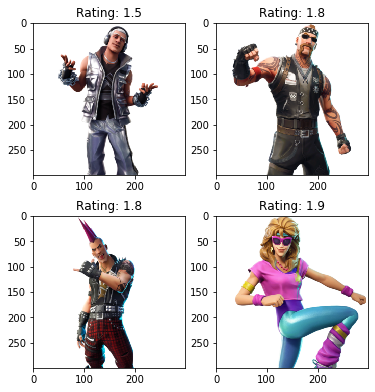

In [95]:
bad_skins = skins[skins['rating'] < 2].sort_values('rating')

fig, ax = plt.subplots(2,2,figsize=(6,6.5))

x = 0
for i in range(2):
    for j in range(2):
        try:
            url = bad_skins['pic'].iloc[x]
            resp = requests.get(url)
            img = Image.open(BytesIO(resp.content))
            ax[i][j].imshow(img, cmap=plt.cm.binary)
            ax[i][j].set_title("Rating: {}".format(bad_skins['rating'].iloc[x]))
            x += 1
        except:
            None

Looking at the skins rated below 2, a trend among most of them are that they're very punk rock/biker.
* **The community dislikes skins that resemble punk rock/biker males.**
* It's possible they also dislike extremely colorful female skins.

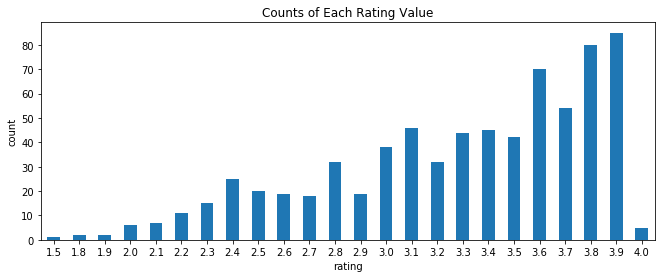

In [96]:
plt.figure(figsize=(11,4))
skins['rating'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('rating')
plt.ylabel('count')
plt.title("Counts of Each Rating Value");

* Only 0.7% of skins are rated below 2.
* No skins are rated above 4.
* **The distribution of ratings is leaning towards the right - the higher end of the interval. Overall, people generally like the skins the Fortnite staff produce.**

### Number of Votes

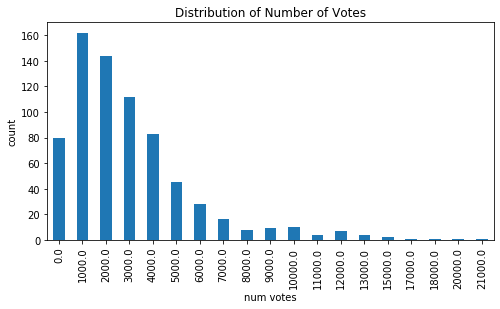

In [98]:
plt.figure(figsize=(8,4))
skins['num_votes'].round(-3).value_counts().sort_index().plot(kind='bar')
plt.xlabel("num votes")
plt.ylabel("count")
plt.title("Distribution of Number of Votes");

In [99]:
print("min number of votes:", skins['num_votes'].min())
print("max number of votes:", skins['num_votes'].max())
print("average number of votes:", round(skins['num_votes'].mean()))

min number of votes: 72.0
max number of votes: 20900.0
average number of votes: 3026


In [100]:
skins[skins['num_votes'] < 100]

,name,set,availability,rarity,rating,num_votes,categories,pic
396,Mincemeat,Baker's Nightmare,Shop,Epic,3.4,89.0,['Male'],https://progameguides.com/wp-content/uploads/2...
417,Nap Cap’n,Bedhead Brigade,Shop,Rare,3.4,90.0,"['Male', 'Styles']",https://progameguides.com/wp-content/uploads/2...
434,Original Renegade,Origins,Shop,Uncommon,3.3,91.0,"['Male', 'Styles']",https://progameguides.com/wp-content/uploads/2...
435,Orin,Y-Labs-Rescue,Unreleased,Rare,3.9,85.0,['Male'],https://progameguides.com/wp-content/uploads/2...
539,Sgt. Snooze,Bedhead Brigade,Shop,Rare,3.0,72.0,"['Male', 'Styles']",https://progameguides.com/wp-content/uploads/2...
576,Slumberjack,Bedhead Brigade,Shop,Rare,3.7,86.0,"['Male', 'Styles']",https://progameguides.com/wp-content/uploads/2...


There are 6 skins that have ratings less than 100. The lack of votes can be seen as inadequate since it's not a large enough portion of the community, but most (if not all) of these skins came out within the past 1-2 months. Since they are more recent, I would consider them more valuable since they resemble today's thinking. Skins released closer to today are expected to not have as many ratings as those released years ago.

### Categories

In [101]:
skins['categories'] = skins['categories'].apply(clean_categories)

In [102]:
all_categories = []
for i in range(len(skins['categories'])):
    for category in skins['categories'].iloc[i]:
        if category != "":
            all_categories.append(category)

The 15 most common categories will be analyzed (the remaining categories have a count less than 10).

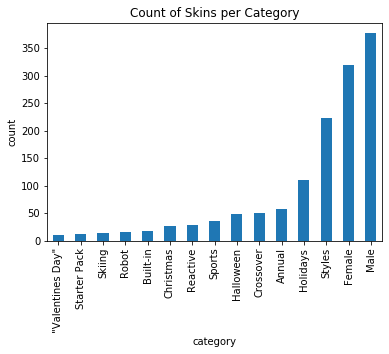

In [103]:
common_cats = pd.Series(all_categories).value_counts().iloc[:15]
common_cats.sort_values().plot(kind="bar")
plt.xlabel("category")
plt.ylabel("count")
plt.title('Count of Skins per Category');

* As expected, the top two most common categories are Male and Female.
* The 3rd most common category is Styles. This category is for the skins that are edits of other skins, ie. a differet color variation of a skin.

In [104]:
skins['categories'] = skins['categories'].apply(str)
category_ratings = []
for category in common_cats.index:
    cat_mean = skins[skins['categories'].str.contains(category)]['rating'].mean()
    category_ratings.append(cat_mean)

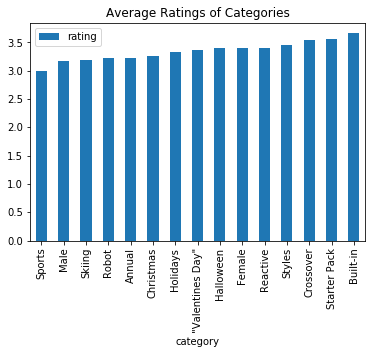

In [105]:
pd.DataFrame({'category': common_cats.index, 'rating': category_ratings}).set_index('category').sort_values('rating').plot(kind='bar')
plt.title('Average Ratings of Categories');

The difference in mean ratings between categories is not large - all of the top 15 categories have mean ratings within a 0.5 span (between 3.0 and 3.5).

## Model - Only Images

Downloading images from their urls into vector form and lowering the resolution to 128x128 for faster processing.

In [108]:
# downloading image matrices
imgs = []
for url in skins['pic']:
    resp = requests.get(url)
    img = Image.open(BytesIO(resp.content))
    img = img.resize((128,128)).convert('RGBA')
    imgs.append(np.array(img))

In [109]:
image_matrices = np.array(imgs)
image_matrices.shape

(718, 128, 128, 4)

In [110]:
y = skins['rating']
X_train, X_test, Y_train, Y_test = train_test_split(image_matrices, y, test_size=0.2, random_state=1)

In [111]:
X_train.shape

(574, 128, 128, 4)

In [112]:
X_train = X_train / 255  # rescaling pixels
y_scaled = Y_train / 5   # scaling ratings

In [113]:
np.random.seed(0) 
tf.random.set_seed(0)

In [114]:
# final image model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 4)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [115]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 127009    
Total params: 128,193
Trainable params: 128,193
Non-trainable params: 0
_________________________________________________________________


In [116]:
# compilation
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [117]:
# fitting the model
history = model.fit(X_train, y_scaled, epochs=40, batch_size=100, verbose=1, validation_split=0.2)

Epoch 1/40
5/5 [==============================] - 2s 494ms/step - loss: 26.9951 - mse: 26.9951 - mae: 3.8280 - val_loss: 35.7803 - val_mse: 35.7803 - val_mae: 5.6723
Epoch 2/40
5/5 [==============================] - 2s 360ms/step - loss: 16.1686 - mse: 16.1686 - mae: 3.0639 - val_loss: 8.5210 - val_mse: 8.5210 - val_mae: 2.8363
Epoch 3/40
5/5 [==============================] - 2s 328ms/step - loss: 10.5650 - mse: 10.5650 - mae: 3.1183 - val_loss: 3.3564 - val_mse: 3.3564 - val_mae: 1.7792
Epoch 4/40
5/5 [==============================] - 2s 366ms/step - loss: 1.1548 - mse: 1.1548 - mae: 0.8553 - val_loss: 1.3171 - val_mse: 1.3171 - val_mae: 1.0540
Epoch 5/40
5/5 [==============================] - 3s 525ms/step - loss: 2.2474 - mse: 2.2474 - mae: 1.3957 - val_loss: 1.9230 - val_mse: 1.9230 - val_mae: 1.3228
Epoch 6/40
5/5 [==============================] - 3s 549ms/step - loss: 1.2949 - mse: 1.2949 - mae: 1.0672 - val_loss: 0.2384 - val_mse: 0.2384 - val_mae: 0.4548
Epoch 7/40
5/5 [====

In [118]:
predictions = model.predict(X_train)
pred = np.round(predictions * 5, 1).flatten()
true = Y_train
result = pd.DataFrame({"true": true, "pred": pred})
result["abs difference"] = abs(result['true'] - result['pred'])
result.head()

,true,pred,abs difference
34,4.0,4.1,0.1
185,2.8,3.2,0.4
154,3.9,3.6,0.3
716,3.8,3.4,0.4
671,3.8,3.0,0.8


In [119]:
print("Mean absolute error", round(result['abs difference'].mean(), 2))

Mean absolute error 0.36


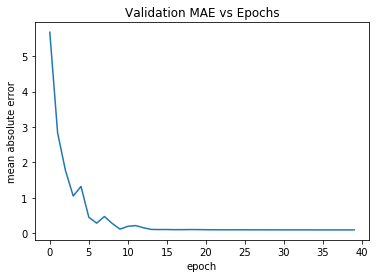

In [120]:
plt.plot(history.history['val_mae'])
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.title("Validation MAE vs Epochs");

Validation

In [121]:
X_test = X_test / 255
Y_test = Y_test / 5

In [122]:
predictions = model.predict(X_test)
pred = np.round(predictions * 5, 1).flatten()
true = Y_test * 5
test_result = pd.DataFrame({"true": true, "pred": pred})
test_result["abs difference"] = abs(test_result['true'] - test_result['pred'])
test_result.head()

,true,pred,abs difference
59,3.5,3.7,0.2
60,3.9,3.2,0.7
214,3.6,3.4,0.2
640,3.1,3.0,0.1
8,3.8,3.5,0.3


In [123]:
print("Mean absolute error", round(test_result['abs difference'].mean(), 2))

Mean absolute error 0.48


In [124]:
min_diff = test_result["abs difference"].min()
max_diff = test_result["abs difference"].max()
print("Min test difference:", round(min_diff, 2))
print("Max test difference:", round(max_diff, 2))

Min test difference: 0.0
Max test difference: 1.6


In [125]:
# saving the model
# model.save('skin_image_model.h5')

In [126]:
skin_image_model = tf.keras.models.load_model('skin_image_model.h5')

predictions = skin_image_model.predict(X_test)
pred = np.round(predictions * 5, 1).flatten()
true = Y_test * 5
image_test_result = pd.DataFrame({"true": true, "pred": pred})
image_test_result["abs difference"] = abs(image_test_result['true'] - image_test_result['pred'])
image_test_result.head()

,true,pred,abs difference
59,3.5,3.7,0.2
60,3.9,3.2,0.7
214,3.6,3.4,0.2
640,3.1,3.0,0.1
8,3.8,3.5,0.3


In [127]:
print("Image Model - Mean absolute error (Test)", round(np.mean(image_test_result['abs difference']), 2))

Image Model - Mean absolute error (Test) 0.48


## Ensemble
Goal: reduce the MAE by using more information (additional features: categories, rarity) by ensembling the image predictions with this newer model's predictions, used for categorical data

In [128]:
# getting the value counts of each unique category
unique_cats = []
skins['categories'] = skins['categories'].apply(clean_categories)
for row in skins['categories']:
    for item in row:
        if item != '':
            unique_cats.append(item)

top_categories = pd.Series(unique_cats).value_counts().iloc[:16].index
top_categories

Index(['Male', 'Female', 'Styles', 'Holidays', 'Annual', 'Crossover',
       'Halloween', 'Sports', 'Reactive', 'Christmas', 'Built-in', 'Robot',
       'Skiing', 'Starter Pack', '"Valentines Day"', 'Mystery Skin'],
      dtype='object')

The top 16 most common categories will be used to reduce dimensionality (eliminating uncommon labels).

In [129]:
def remove_uncommon(categories):
    result = []
    for category in categories:
        if category in top_categories:
            result.append(category)
    return result

skins['categories'] = skins['categories'].apply(remove_uncommon)
skins.head()

,name,set,availability,rarity,rating,num_votes,categories,pic
0,8-Ball vs Scratch,Stripes and Solids,Battle Pass,Epic,3.9,10000.0,"[Male, Styles]",https://progameguides.com/wp-content/uploads/2...
1,A.I.M.,A.I.M.,Battle Pass,Legendary,3.1,14600.0,"[Male, Mystery Skin, Robot]",https://progameguides.com/wp-content/uploads/2...
2,Absolute Zero,Arctic Command,Shop,Rare,2.7,11700.0,[Male],https://progameguides.com/wp-content/uploads/2...
3,Abstrakt,Aerosol Assassins,Shop,Epic,3.2,11900.0,[Male],https://progameguides.com/wp-content/uploads/2...
4,Adeline,Colorway,Shop,Rare,3.3,941.0,[Styles],https://progameguides.com/wp-content/uploads/2...


In [130]:
from sklearn.preprocessing import MultiLabelBinarizer

# one-hot encoding categories
mlb = MultiLabelBinarizer()
categories = pd.DataFrame(mlb.fit_transform(skins['categories']),columns=mlb.classes_, index=skins.index)
categories.head()

,"""Valentines Day""",Annual,Built-in,Christmas,Crossover,Female,Halloween,Holidays,Male,Mystery Skin,Reactive,Robot,Skiing,Sports,Starter Pack,Styles
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [131]:
# one-hot encoding rarity
rarities = pd.get_dummies(skins['rarity'])
rarities.head()

,DC,Dark,Epic,Frozen,Gaming Legends,Icon,Lava,Legendary,Marvel,Rare,Shadow,Slurp,Star Wars,Uncommon
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [132]:
# combining the category and rarity one-hots
cat_rare = pd.merge(categories, rarities, left_index=True, right_index=True)

In [146]:
x_train, x_test, y_train, y_test = train_test_split(cat_rare, skins['rating'], test_size=0.2, random_state=1)

Regression models:
* linear regression
* decision tree
* random forest
* gradient boost

In [147]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_preds = lr.predict(x_train)

dt = DecisionTreeRegressor(random_state=42)
dt.fit(x_train, y_train)
dt_preds = dt.predict(x_train)

rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_train)

gd = GradientBoostingRegressor(random_state=42)
gd.fit(x_train, y_train)
gd_preds = gd.predict(x_train)

In [148]:
rarity_categories = pd.DataFrame({"true": y_train, "logreg": lr_preds, "decision tree": dt_preds, 
                                 "random forest": rf_preds, "gradient boost": gd_preds})
rarity_categories.head()

,true,logreg,decision tree,random forest,gradient boost
34,4.0,3.970124,4.000000,3.899383,3.869965
185,2.8,3.237258,3.400000,3.397916,3.338559
154,3.9,3.375978,3.684615,3.681100,3.484623
716,3.8,3.339883,3.408000,3.409559,3.379959
671,3.8,3.993273,3.800000,3.817533,3.833649


In [149]:
# MAEs of all the predictors - decision tree did the best on the train data
lr_mae = round(np.mean(abs(y_train - rarity_categories["logreg"])), 3)
dt_mae = round(np.mean(abs(y_train - rarity_categories["decision tree"])), 3)
rf_mae = round(np.mean(abs(y_train - rarity_categories["random forest"])), 3)
gb_mae = round(np.mean(abs(y_train - rarity_categories["gradient boost"])), 3)

print("linear regression MAE:", lr_mae)
print("decision tree MAE:", dt_mae)
print("random forest MAE:", rf_mae)
print("gradient boost MAE:", gb_mae)

linear regression MAE: 0.357
decision tree MAE: 0.265
random forest MAE: 0.284
gradient boost MAE: 0.319


The decision tree regressor performed the best on the training data. The random forest regressor also did nearly as well and is normally considered better due to its reduction in variance. Because of this, I chose to use the random forest regressor for the ensemble. 

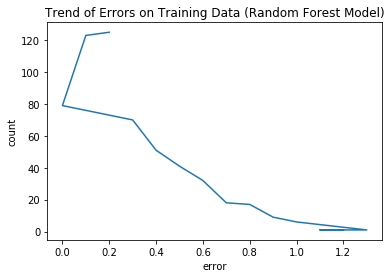

In [150]:
wrongs = round(abs(y_train - rarity_categories["random forest"]).sort_values(), 1).value_counts()
plt.plot(wrongs.index, wrongs.values)
plt.xlabel("error")
plt.ylabel("count")
plt.title("Trend of Errors on Training Data (Random Forest Model)");

### Ensembling the two models

Weighted average - what should the weights be? The random forest model has a lower train MAE compared to the image model. I will put slightly more weight on this model.

In [151]:
image_train_preds = skin_image_model.predict(X_train) * 5
rf_train_preds = rarity_categories["random forest"]

In [152]:
ensemble_train_mae = np.mean(abs(y_train - ((.65 * rf_train_preds) + (.35 * image_train_preds.flatten()))))
print("New train MAE (Ensemble):", round(ensemble_train_mae, 2))

New train MAE (Ensemble): 0.29


This ensembled train MAE is very similar to the random forest train MAE (.006 difference). It's also better than the image model's train MAE of .36 while keeping the image analysis.  

Now let's look at test MAEs:

In [153]:
# MAE of the random forest regressor
rf_test_preds = rf.predict(x_test)
print("Test MAE (Random Forest):", round(np.mean(abs(rf.predict(x_test) - y_test)), 3))

Test MAE (Random Forest): 0.335


In [154]:
# taking a weighted average of the two predictions (image CNN and random forest)
ensembled_preds = (.65 * rf_test_preds) + (.35 * image_test_result['pred'])
ensemble = pd.DataFrame({"true": y_test.values, "pred": round(ensembled_preds, 1)})
ensemble.head()

,true,pred
59,3.5,3.7
60,3.9,3.6
214,3.6,3.3
640,3.1,3.1
8,3.8,3.2


In [155]:
# MAE of the ensembled predictions
print("Test MAE (Ensemble):", round(np.mean(abs(ensemble['true'] - ensemble['pred'])), 4))

Test MAE (Ensemble): 0.3528


**The test MAE went from .48 (only images as input) to .35 (with categories and rarity)!** This means that on average, a prediction is about .35 off. For example, if a skin got a rating of 4.5 out of 5, the true rating is on average +/- .35 away from that value. It can be around [4.15, 4.85]. 

This is good because a range of [4.15, 4.85] still shows that the skin is very liked. It also works the other way around - a range of [2.15, 2.85] would indicate that the skin would likely be disliked.

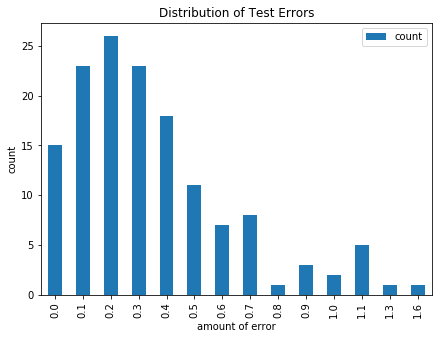

In [157]:
test_wrongs = abs(ensemble["true"] - ensemble["pred"])
counts = pd.DataFrame(test_wrongs.value_counts().sort_index()).reset_index()
counts['index'] = counts['index'].round(1)
counts = counts.groupby('index').sum().rename(columns={0: "count"})
counts.index.names = ["amount of error"]
counts.reset_index().plot.bar(x="amount of error", y="count", figsize=(7,5))
plt.title("Distribution of Test Errors")
plt.ylabel("count");

* The distribution of test errors is centered around 0.2.
* There are 13 out of 144 test predictions that have an error above 0.7.

Let's see which images received the largest errors.

In [160]:
# Top 12 skins with largest errors
ensemble["error"] = abs(ensemble["true"] - ensemble["pred"])
top_errors = ensemble.sort_values("error", ascending=False).iloc[:12]
top_errors.head()

,true,pred,error
609,1.5,3.1,1.6
607,2.0,3.3,1.3
274,2.0,3.1,1.1
118,2.3,3.4,1.1
350,2.4,3.5,1.1


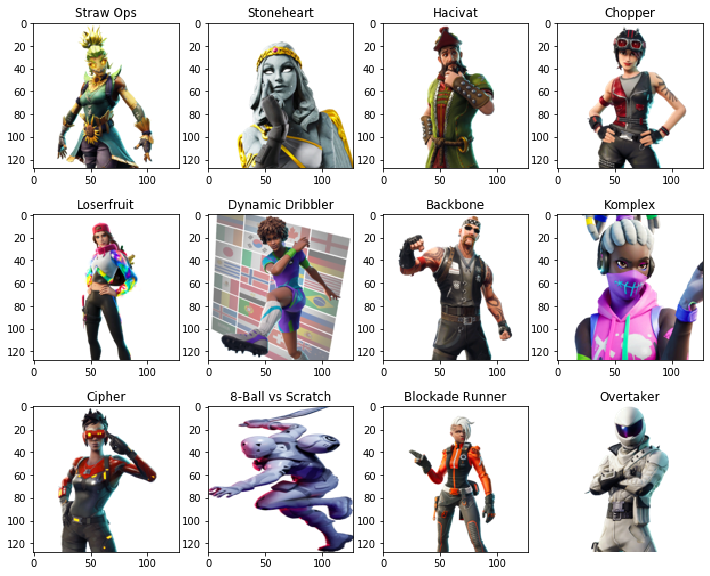

In [193]:
fig, ax = plt.subplots(3,4,figsize=(12,10))

pic, x = top_errors.index, 0
for i in range(3):
    for j in range(4):
        label = pic[x]
        img = Image.fromarray(image_matrices[label])
        ax[i][j].imshow(img, cmap=plt.cm.binary)
        ax[i][j].set_title(skins['name'].iloc[pic[x]])
        x += 1

Looking at the top 12 skins with the highest errors, I cannot pinpoint any particular trend among them.

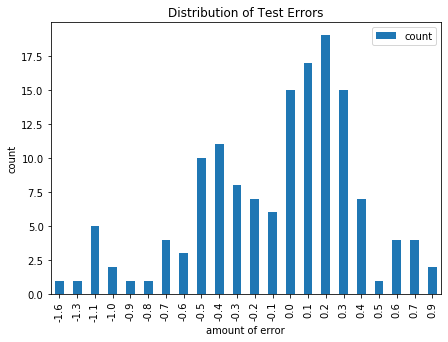

In [165]:
test_error = ensemble["true"] - ensemble["pred"]
error_counts = pd.DataFrame(test_error.value_counts().sort_index()).reset_index()
error_counts['index'] = error_counts['index'].round(1)
error_counts = error_counts.groupby('index').sum().rename(columns={0: "count"})
error_counts.index.names = ["amount of error"]
error_counts.reset_index().plot.bar(x="amount of error", y="count", figsize=(7,5))
plt.title("Distribution of Test Errors")
plt.ylabel("count");

In [173]:
test_error.mean()

-0.07083333333333336

Seeing that the mean of the (not absolute) errors is around 0, **we can say that the errors aren't leaning towards a certain direction** - the model does not always overestimate, neither does it always underestimating.

When looking at the 13 skins with errors larger than 0.7, 11 of the 13 skins received a negative error. Only 2 of the errors were positive. Considering this, **we can also say that the model tends to overestimate when the errors are larger.**

## What factors could cause errors?

1) There are anomalies among the skin ratings. A skin below, named Renegade Raider, is widely considered ugly but it still has a rating near 4. This is because it's the rarest skin in the game. It is considered ugly and would normally be rated low, and skins like these could also be confusing the neural net.

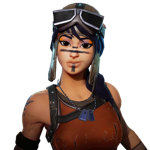

In [176]:
url = "https://progameguides.com/wp-content/uploads/2019/04/fortnite-renegade-raider-icon-png.png"
resp = requests.get(url)
Image.open(BytesIO(resp.content)).resize((150,150))

2) There are skins that look very similar yet have drastically different ratings.

* Example 1: Tomatoheads - Left rating: 2.7, Right rating: 3.6

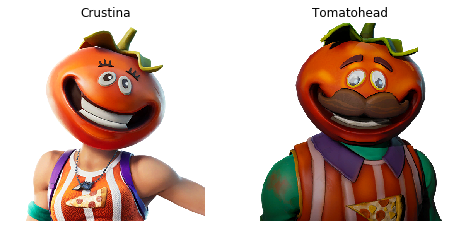

In [194]:
# Crustina
url = "https://progameguides.com/wp-content/uploads/2020/08/fortnite-crustina-skin-icon.png"
resp = requests.get(url)
img1 = Image.open(BytesIO(resp.content))

# Tomatohead
url = "https://progameguides.com/wp-content/uploads/2019/04/fortnite-tomatohead-icon-png.png"
resp = requests.get(url)
img2 = Image.open(BytesIO(resp.content))

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1)
ax1.set_title("Crustina")
plt.axis('off')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2)
ax2.set_title("Tomatohead")
plt.axis('off');

* Example 2: Team Leaders - Left rating: 3.8, Right rating: 3.2

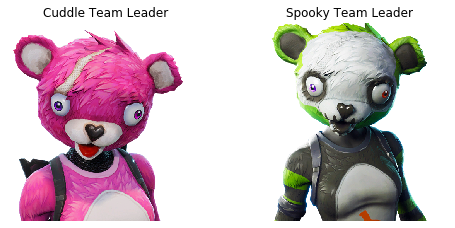

In [195]:
# Cuddle Team Leader
url = "https://progameguides.com/wp-content/uploads/2019/04/fortnite-cuddle-team-leader-icon-png.png"
resp = requests.get(url)
img1 = Image.open(BytesIO(resp.content))

# Spooky Team Leader
url = "https://progameguides.com/wp-content/uploads/2019/04/fortnite-spooky-team-leader-icon-png.png"
resp = requests.get(url)
img2 = Image.open(BytesIO(resp.content))

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1)
ax1.set_title("Cuddle Team Leader")
plt.axis('off')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2)
ax2.set_title("Spooky Team Leader")
plt.axis('off');

* Example 3: Banshee variations - Left rating: 2.2, Right rating: 3.6

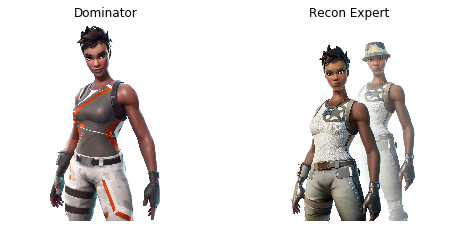

In [196]:
# Dominator
url = "https://progameguides.com/wp-content/uploads/2019/04/fortnite-dominator-featured-png.png"
resp = requests.get(url)
img1 = Image.open(BytesIO(resp.content))

# Recon Expert
url = "https://progameguides.com/wp-content/uploads/2018/08/fortnite-recon-soldier-skin-featured.png"
resp = requests.get(url)
img2 = Image.open(BytesIO(resp.content))

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1)
ax1.set_title("Dominator")
plt.axis('off')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2)
ax2.set_title("Recon Expert")
plt.axis('off');

3) Picture format varies. Some images of skins contain another shadow-like figure behind them. The recon expert skin above is an example of this.

There are two other examples that showed up earlier in this notebook:

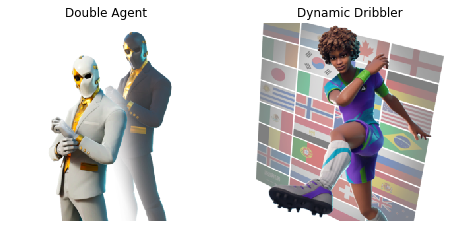

In [197]:
url = skins[skins['set'] == 'Double Agent']['pic'].iloc[2]
resp = requests.get(url)
img1 = Image.open(BytesIO(resp.content))

url = skins[skins['name'] == 'Dynamic Dribbler']['pic'].iloc[0]
resp = requests.get(url)
img2 = Image.open(BytesIO(resp.content))

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1)
ax1.set_title("Double Agent")
plt.axis('off')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2)
ax2.set_title("Dynamic Dribbler")
plt.axis('off');

Another format difference is that some images in the dataset are full body portraits and some are headshots. Some skins don't have full body portraits (eg. https://progameguides.com/fortnite-cosmetic/a-i-m/ at the PNG section). The A.I.M skin only has a headshot shown below.

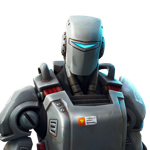

In [198]:
url = "https://progameguides.com/wp-content/uploads/2018/11/fortnite-aim-icon-png.png"
resp = requests.get(url)
Image.open(BytesIO(resp.content)).resize((150,150))

From this headshot, you can see how much less information we gain of how a skin looks like. This is why I favor full body portraits instead of making this dataset headshot-only, although that would've added consistency. I believe that the model would perform much better if I had access to full body portraits of all the skins.

All skins had a variation of what I mean as a full body portrait. An example is below:

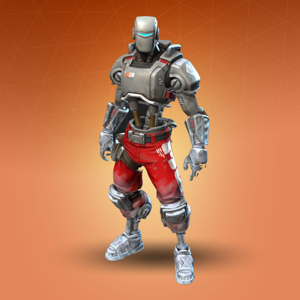

In [200]:
url = "https://progameguides.com/wp-content/uploads/2018/11/fortnite-outfit-aim-1.jpg"
resp = requests.get(url)
Image.open(BytesIO(resp.content)).resize((300,300))

These may work, but I decided not to use these at the beginning of the project because background. I did not want the background to affect the model. Not all of the backgrounds are orange, and some are even more distracting. Here's an example:

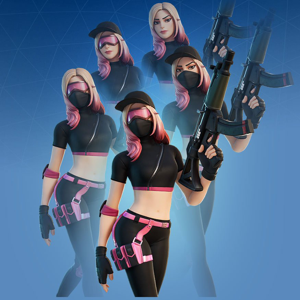

In [201]:
url = "https://progameguides.com/wp-content/uploads/2020/08/fortnite-outfit-atheleisure-asassin.jpg"
resp = requests.get(url)
Image.open(BytesIO(resp.content)).resize((300,300))

## What would be next?

To suggest a next step, I think it would be interesting to scrape how much v-bucks each skin costs and see how strong price correlates with the ratings. It would be ideal to have price correlate with the ratings because if people like a skin a lot, then they can charge more for it.

It would also be interesting to see how well a project like this does with Valorant skins since kill animation and ammunition skins are large confounding factors to why someone would buy a skin.